# Analysing GITT data

PyProBE includes built-in analysis methods for pulsing experiments, which this example
will demonstrate.

First import the required libraries and data:

In [1]:
%%capture
%pip install matplotlib

In [2]:
import pyprobe
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
info_dictionary = {
    "Name": "Sample cell",
    "Chemistry": "NMC622",
    "Nominal Capacity [Ah]": 0.04,
    "Cycler number": 1,
    "Channel number": 1,
}
data_directory = "../../../tests/sample_data/neware"

# Create a cell object
cell = pyprobe.Cell(info=info_dictionary)
cell.add_procedure(
    procedure_name="Sample",
    folder_path=data_directory,
    filename="sample_data_neware.parquet",
)
print(cell.procedure["Sample"].experiment_names)

['Initial Charge', 'Break-in Cycles', 'Discharge Pulses']


We will plot the Break-in Cycles and Discharge Pulses:

Text(0, 0.5, 'Voltage [V]')

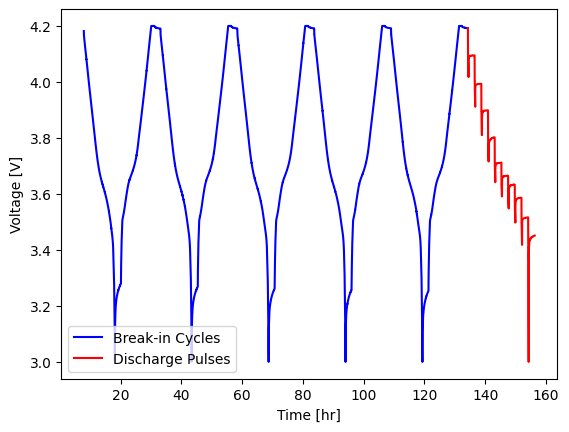

In [4]:
fig, ax = plt.subplots()
cell.procedure["Sample"].experiment("Break-in Cycles").plot(
    x="Time [hr]", y="Voltage [V]", ax=ax, label="Break-in Cycles", color="blue"
)
cell.procedure["Sample"].experiment("Discharge Pulses").plot(
    x="Time [hr]", y="Voltage [V]", ax=ax, label="Discharge Pulses", color="red"
)
ax.set_ylabel("Voltage [V]")

State-of-charge is a useful metric when working with battery data, however it must be carefully defined. PyProBE doesn't automatically calculate a value for cell SOC until instructed to by the user for this reason.

To add an SOC column to the data, we call `set_SOC()` on the procedure. We are going to provide an argument to `reference_charge`. This will be the final charge of the break-in cycles. This argument instructs PyProBE that the final data point of this charge is our 100% SOC reference.

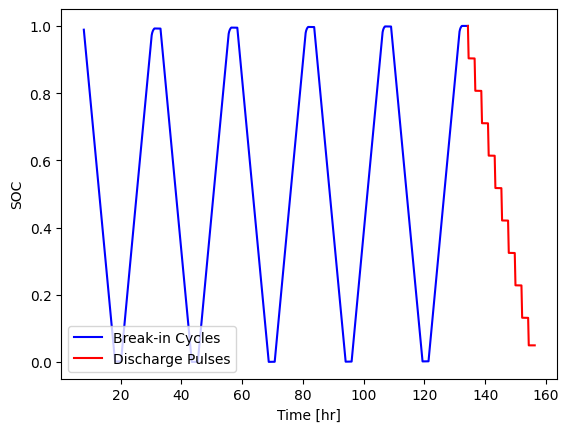

In [5]:
reference_charge = cell.procedure["Sample"].experiment("Break-in Cycles").charge(-1)
cell.procedure["Sample"].set_SOC(reference_charge=reference_charge)

fig, ax = plt.subplots()
cell.procedure["Sample"].experiment("Break-in Cycles").plot(
    x="Time [hr]", y="SOC", ax=ax, label="Break-in Cycles", color="blue"
)
cell.procedure["Sample"].experiment("Discharge Pulses").plot(
    x="Time [hr]", y="SOC", ax=ax, label="Discharge Pulses", color="red"
)
ax.set_ylabel("SOC")
plt.legend(loc="lower left")

Then we'll filter to only the pulsing experiment:

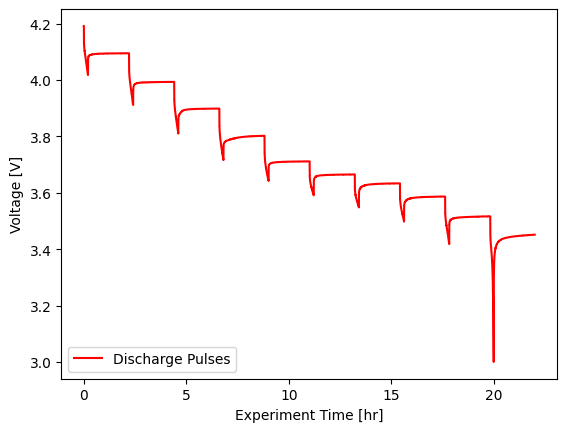

In [6]:
pulsing_experiment = cell.procedure["Sample"].experiment("Discharge Pulses")

fig, ax = plt.subplots()
pulsing_experiment.plot(
    x="Experiment Time [hr]",
    y="Voltage [V]",
    ax=ax,
    label="Discharge Pulses",
    color="red",
)
ax.set_ylabel("Voltage [V]")
plt.legend(loc="lower left")

And then create our pulsing analysis object.

In [7]:
from pyprobe.analysis import pulsing

pulse_object = pulsing.Pulsing(input_data=pulsing_experiment)

With the pulsing object we can separate out individual pulses:

Text(0, 0.5, 'Voltage [V]')

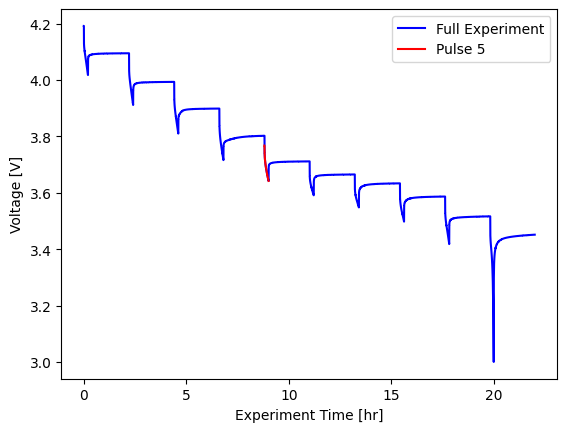

In [8]:
fig, ax = plt.subplots()
pulse_object.input_data.plot(
    x="Experiment Time [hr]",
    y="Voltage [V]",
    label="Full Experiment",
    color="blue",
    ax=ax,
)
pulse_object.pulse(4).plot(
    x="Experiment Time [hr]", y="Voltage [V]", label="Pulse 5", color="red", ax=ax
)
ax.set_ylabel("Voltage [V]")

We can also extract key parameters from the pulsing experiment, with the `get_resistances()` method.

In [9]:
pulse_resistances = pulsing.get_resistances(input_data=pulsing_experiment)
print(pulse_resistances.data)

shape: (10, 5)
┌──────────┬───────────┬──────────────┬─────────┬───────────────┐
│ SOC      ┆ R0 [Ohms] ┆ Pulse Number ┆ OCV [V] ┆ Capacity [Ah] │
│ ---      ┆ ---       ┆ ---          ┆ ---     ┆ ---           │
│ f64      ┆ f64       ┆ u32          ┆ f64     ┆ f64           │
╞══════════╪═══════════╪══════════════╪═════════╪═══════════════╡
│ 1.0      ┆ 1.805578  ┆ 1            ┆ 4.1919  ┆ 0.062214      │
│ 0.903497 ┆ 1.835632  ┆ 2            ┆ 4.0949  ┆ 0.058214      │
│ 0.806994 ┆ 1.775612  ┆ 3            ┆ 3.9934  ┆ 0.054213      │
│ 0.710493 ┆ 1.750596  ┆ 4            ┆ 3.8987  ┆ 0.050213      │
│ 0.613991 ┆ 1.725532  ┆ 5            ┆ 3.8022  ┆ 0.046213      │
│ 0.517489 ┆ 1.705558  ┆ 6            ┆ 3.7114  ┆ 0.042212      │
│ 0.420988 ┆ 1.705622  ┆ 7            ┆ 3.665   ┆ 0.038212      │
│ 0.324487 ┆ 1.735555  ┆ 8            ┆ 3.6334  ┆ 0.034212      │
│ 0.227986 ┆ 1.795638  ┆ 9            ┆ 3.5866  ┆ 0.030212      │
│ 0.131485 ┆ 1.900663  ┆ 10           ┆ 3.5164  ┆ 0.026211   

The `get_resistances()` method can take an argument of a list of times at which to evaluate the resistance after the pulse, for instance at 10s after the pulse:

In [10]:
pulse_resistances = pulsing.get_resistances(input_data=pulsing_experiment, r_times=[10])
print(pulse_resistances.data)

shape: (10, 6)
┌──────────┬───────────┬──────────────┬──────────────┬─────────┬───────────────┐
│ SOC      ┆ R0 [Ohms] ┆ Pulse Number ┆ R_10s [Ohms] ┆ OCV [V] ┆ Capacity [Ah] │
│ ---      ┆ ---       ┆ ---          ┆ ---          ┆ ---     ┆ ---           │
│ f64      ┆ f64       ┆ u32          ┆ f64          ┆ f64     ┆ f64           │
╞══════════╪═══════════╪══════════════╪══════════════╪═════════╪═══════════════╡
│ 1.0      ┆ 1.805578  ┆ 1            ┆ 2.910931     ┆ 4.1919  ┆ 0.062214      │
│ 0.903497 ┆ 1.835632  ┆ 2            ┆ 2.805967     ┆ 4.0949  ┆ 0.058214      │
│ 0.806994 ┆ 1.775612  ┆ 3            ┆ 2.735943     ┆ 3.9934  ┆ 0.054213      │
│ 0.710493 ┆ 1.750596  ┆ 4            ┆ 2.685915     ┆ 3.8987  ┆ 0.050213      │
│ 0.613991 ┆ 1.725532  ┆ 5            ┆ 2.640815     ┆ 3.8022  ┆ 0.046213      │
│ 0.517489 ┆ 1.705558  ┆ 6            ┆ 2.400785     ┆ 3.7114  ┆ 0.042212      │
│ 0.420988 ┆ 1.705622  ┆ 7            ┆ 2.345855     ┆ 3.665   ┆ 0.038212      │
│ 0.324487 ┆ 

As a result object, the pulse summary can also be plotted:

Text(0, 0.5, 'Resistance [Ohms]')

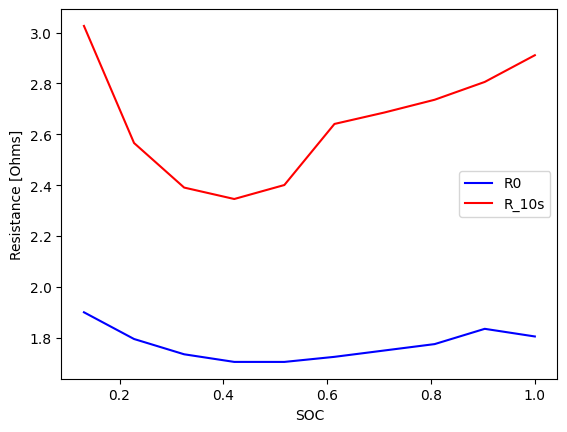

In [11]:
fig, ax = plt.subplots()
pulse_resistances.plot(x="SOC", y="R0 [Ohms]", ax=ax, label="R0", color="blue")
pulse_resistances.plot(x="SOC", y="R_10s [Ohms]", ax=ax, label="R_10s", color="red")
ax.set_ylabel("Resistance [Ohms]")